# Feature Selection
Feature selection for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [2]:
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [4]:
diabetic_data = pd.read_csv(
    DATA_PATH_PROCESSED + 'diabetic_data_cleaned.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Training & Test Split**
Splitting the dataset into training and test sets.

In [5]:
diabetic_data['readmitted'].value_counts(normalize=True) * 100

readmitted
0    90.964015
1     9.035985
Name: proportion, dtype: float64

It's pretty easy to see that there is a strong imbalance between the two classes we want to predict:

- **Late or non-readmission:** ~91%
- **Early-readmission:** ~9%

For this reason, we need to balance the training dataset to ensure that both classes will be predicted properly. Since we can already assume that the training set will drastically reduce in size, we apply a 70-30 split (70% training and 30% test).

In [6]:
# Remove discharge_home since it's highly correlated with discharge_transfer
diabetic_data.drop(columns=['discharge_home', 'medical_internal', 'medical_cardio', 'medical_surgery', 'HbA1c_none', 'HbA1c_norm', 'HbA1c_high_unchanged', 'HbA1c_high_changed'], inplace=True)

In [7]:
# Split in training and test sets
X = diabetic_data.drop(columns='readmitted')
y = diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    diabetic_data.drop(columns='readmitted'),
    y,
    test_size=0.3, # 0.3 or 0.4 is good
    stratify=y,
    random_state=RANDOM_STATE
)

In [8]:
# Add the 'readmitted' column back to the training and test sets
train_data_scaled = X_train.copy()
train_data_scaled['readmitted'] = y_train

test_data_scaled = X_test.copy()
test_data_scaled['readmitted'] = y_test

In [9]:
diabetic_data['readmitted'].value_counts()

readmitted
0    65042
1     6461
Name: count, dtype: int64

In [10]:
train_data_scaled['readmitted'].value_counts()

readmitted
0    45529
1     4523
Name: count, dtype: int64

In [11]:
test_data_scaled['readmitted'].value_counts()

readmitted
0    19513
1     1938
Name: count, dtype: int64

## **2. Undersampling & Oversampling**
Taking care of dataset class imbalance.

We don't want the final training set too small, so we don't want to undersample the majority class too much. But we also don't want to excessively oversample the minority class, since that would cause overfitting for the predictions of the minority class.

We decided to increase by up to an half the number of minority instances, by generating them with SMOTE (Synthetic Minority Over-sampling Technique) to get similar instances (but not duplicates of the original), and to randomly sample the majority instances to a number slightly higher than the minority instances.

In the end, we end up with a test set that is actually bigger than the training set, but in cases like this with strong class imbalance it's perfectly normal.

In [12]:
# Undersample the majority class
undersampler = RandomUnderSampler(sampling_strategy={0: 6_500}, random_state=RANDOM_STATE) # 0.7 is good
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Oversample minority class
smote = SMOTE(sampling_strategy={1: 5_200}, random_state=RANDOM_STATE) # 0.9 or 1.0 is good
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape with RandomUnderSampler', Counter(y_train_resampled))

Original dataset shape Counter({0: 45529, 1: 4523})
Resample dataset shape with RandomUnderSampler Counter({0: 6500, 1: 5200})


ADASYN worked, but slightly worse.
NearMiss would increase a lot the accuracy on the minority class, but would decrease drastically the accuracy on the minority class. This basically means that both classes are strictly interwined.

## **3. Feature Scaling**
Applying scaling to features before running models for feature selection.

In [13]:
NUMERICAL_COLUMNS = [
    'age',
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

In [14]:
# Initialize the StandardScaler
scaler_std = StandardScaler()

X_train_resampled[NUMERICAL_COLUMNS] = scaler_std.fit_transform(X_train_resampled[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler_std.transform(X_test[NUMERICAL_COLUMNS])

## **4. Feature Selection**
Selecting the best $K$ features from the dataset.

In [15]:
# Number of features to select
K = 10 # 10 is good, 7 slightly less good

### 4.1 Random Forest

In [16]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=20,
    max_depth=10,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=20, random_state=38)

In [17]:
y_train_pred = rf.predict(X_train_resampled)
y_test_pred = rf.predict(X_test)

In [18]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6628205128205128
Test accuracy:  0.6266840706726959


In [19]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.76     19513
           1       0.13      0.57      0.22      1938

    accuracy                           0.63     21451
   macro avg       0.53      0.60      0.49     21451
weighted avg       0.86      0.63      0.71     21451



<Axes: >

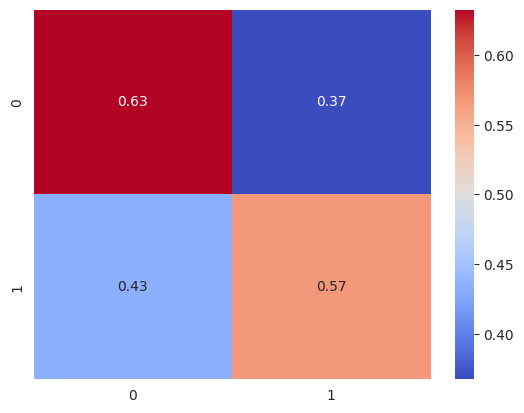

In [20]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [21]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train_resampled.columns, 'importance': rf.feature_importances_})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_rf = features

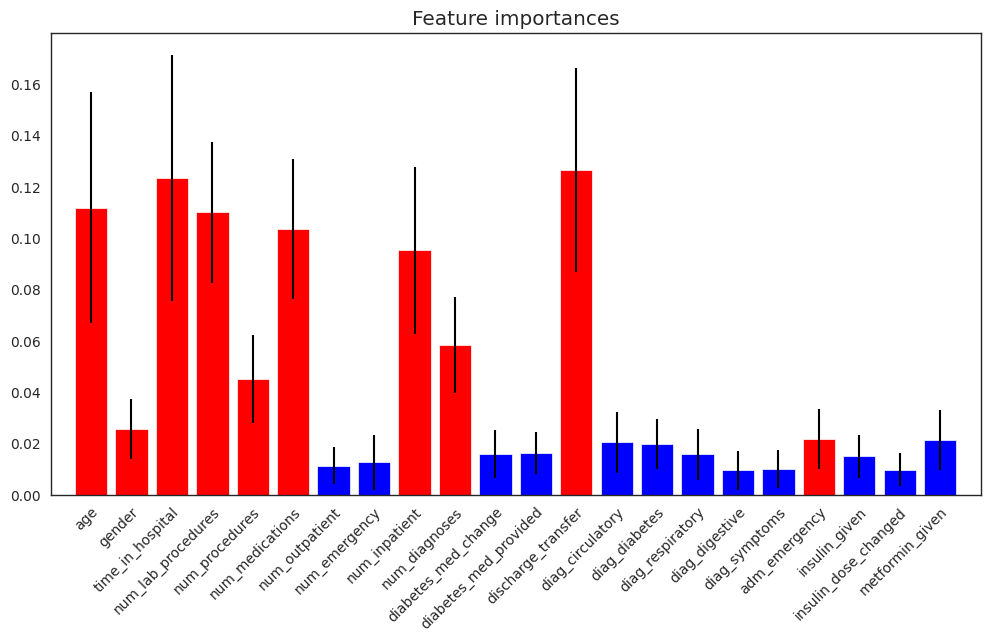

In [22]:
importances_rf = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), importances_rf,
       color=colors, yerr=std, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.1.1 Testing features

In [23]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [24]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [25]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.8323931623931624
Test accuracy:  0.6863083306139574


In [26]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.71      0.80     19513
           1       0.14      0.47      0.21      1938

    accuracy                           0.69     21451
   macro avg       0.53      0.59      0.51     21451
weighted avg       0.86      0.69      0.75     21451



<Axes: >

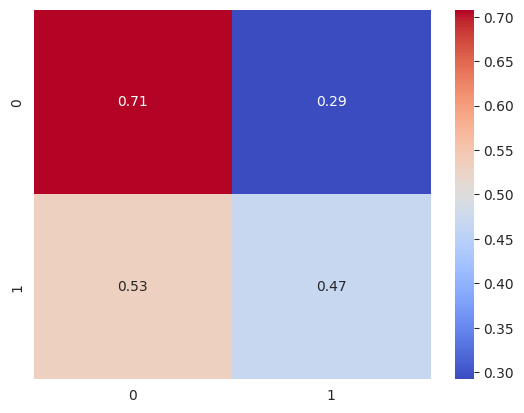

In [27]:
cm_rf = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap='coolwarm')

### 4.2 XGBoost

In [28]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled), # Ratio negative/positive
    random_state=RANDOM_STATE
)
xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=38, ...)

In [29]:
y_train_pred = xgb.predict(X_train_resampled)
y_test_pred = xgb.predict(X_test)

In [30]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.9409401709401709
Test accuracy:  0.6485012353736422


In [31]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     19513
           1       0.12      0.48      0.20      1938

    accuracy                           0.65     21451
   macro avg       0.53      0.57      0.49     21451
weighted avg       0.85      0.65      0.72     21451



<Axes: >

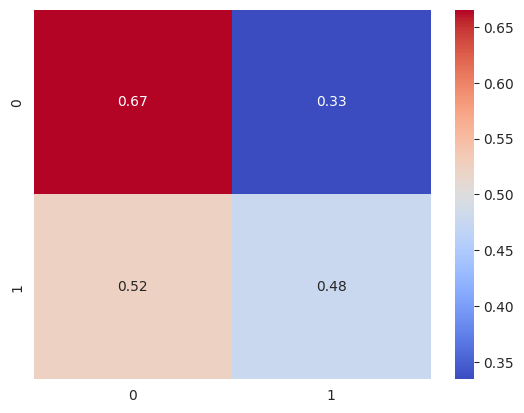

In [32]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [33]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train_resampled.columns, 'importance': xgb.feature_importances_})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_xgb = features

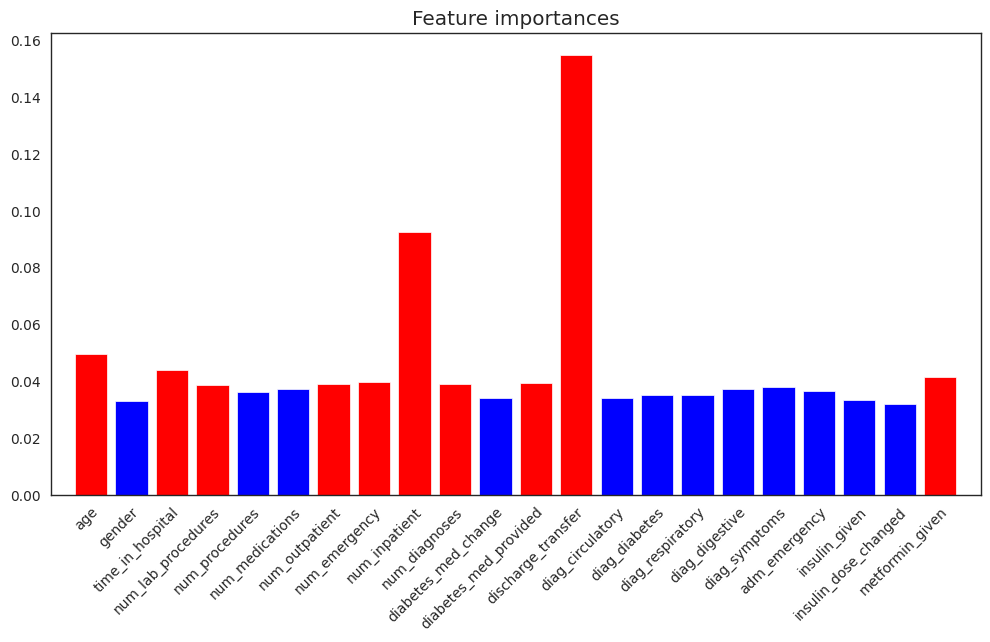

In [34]:
importances_xgb = xgb.feature_importances_
# std = np.std([tree.feature_importances_ for tree in xgb.estimators_],
#              axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), importances_xgb,
       color=colors, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns,  rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.2.1 Testing features

In [35]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [36]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [37]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.765042735042735
Test accuracy:  0.6767516665889702


In [38]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.80     19513
           1       0.14      0.49      0.22      1938

    accuracy                           0.68     21451
   macro avg       0.54      0.59      0.51     21451
weighted avg       0.86      0.68      0.74     21451



<Axes: >

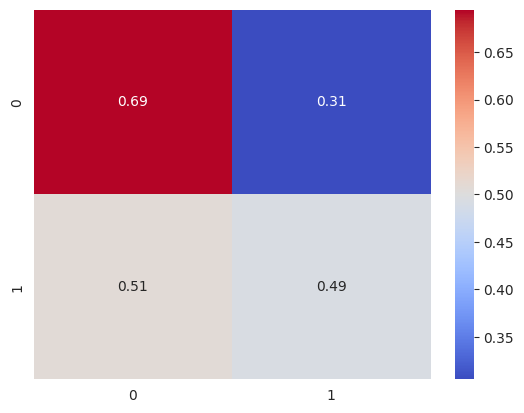

In [39]:
cm_xgb = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_xgb, annot=True, fmt=".2f", cmap='coolwarm')

### 4.3 K-best

In [40]:
def get_feature_univ_scores(univ_fselector, columns):
    return pd.DataFrame(
        data=[univ_fselector.scores_, univ_fselector.pvalues_],
        index=["score", "pvalue"],
        columns=columns,
    ).T

In [41]:
kbest = SelectKBest(k=K)
kbest.fit(X_train_resampled, y_train_resampled)

SelectKBest()

In [42]:
features = X_train_resampled.columns[kbest.get_support()]
features_kbest = features

In [43]:
scores_pvalue = get_feature_univ_scores(kbest, X_train.columns)
importances_kbest = scores_pvalue['score']

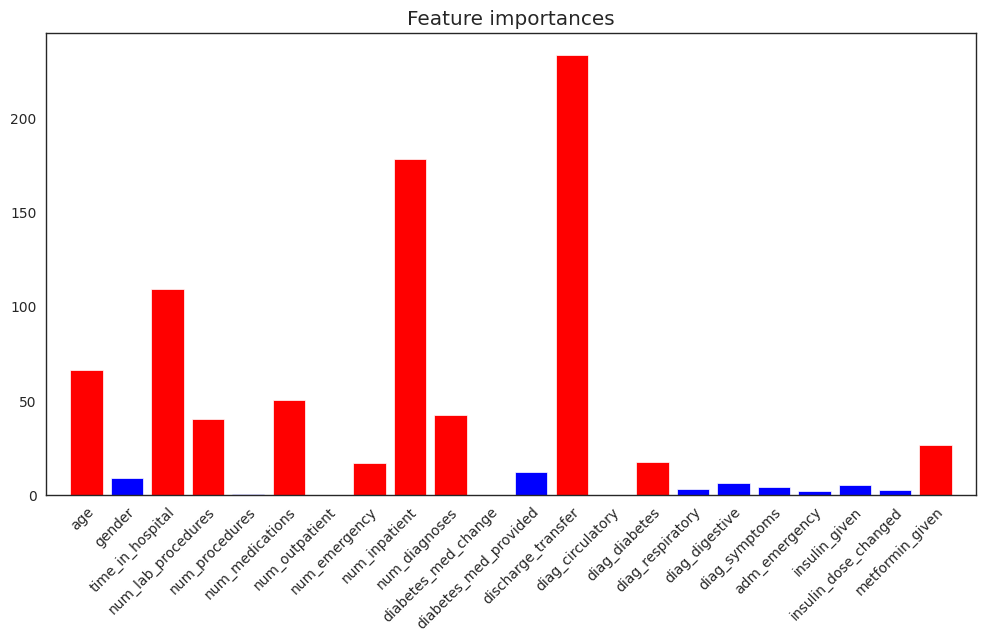

In [44]:
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), scores_pvalue['score'],
       color=colors, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.3.1 Testing features

In [45]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [46]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [47]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.7981196581196581
Test accuracy:  0.6795487389865275


In [48]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     19513
           1       0.14      0.48      0.21      1938

    accuracy                           0.68     21451
   macro avg       0.53      0.59      0.51     21451
weighted avg       0.86      0.68      0.75     21451



<Axes: >

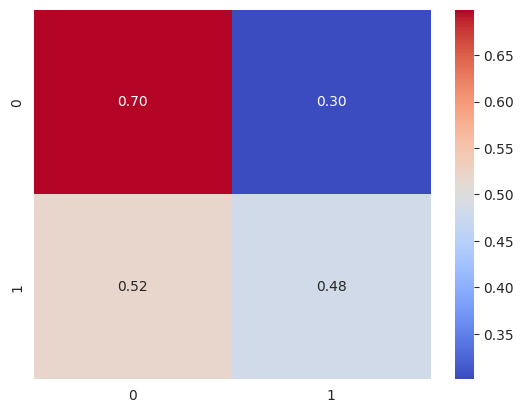

In [49]:
cm_kbest = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_kbest, annot=True, fmt=".2f", cmap='coolwarm')

### 4.4 RFE

In [50]:
def get_feature_rfe_ranking(
    mb_fselector, columns,
):
    return pd.DataFrame(
        data=[mb_fselector.ranking_], index=["ranking"], columns=columns,
    ).T

In [51]:
clf_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=20,
    max_depth=10,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rfe = RFE(
    estimator=clf_rf,
    n_features_to_select=K,
    step=1
)
rfe.fit(X_train_resampled, y_train_resampled)

RFE(estimator=RandomForestClassifier(class_weight='balanced', max_depth=10,
                                     min_samples_leaf=20, random_state=38),
    n_features_to_select=10)

In [52]:
print('Chosen best 10 feature by rfe:', X_train_resampled.columns[rfe.support_])

Chosen best 10 feature by rfe: Index(['age', 'gender', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'num_inpatient', 'num_diagnoses',
       'discharge_transfer', 'insulin_given'],
      dtype='object')


In [53]:
features = X_train_resampled.columns[rfe.support_]
features_rfe = features

In [54]:
feature_rfe = get_feature_rfe_ranking(rfe, X_train_resampled.columns)
importances_rfe = feature_rfe['ranking']

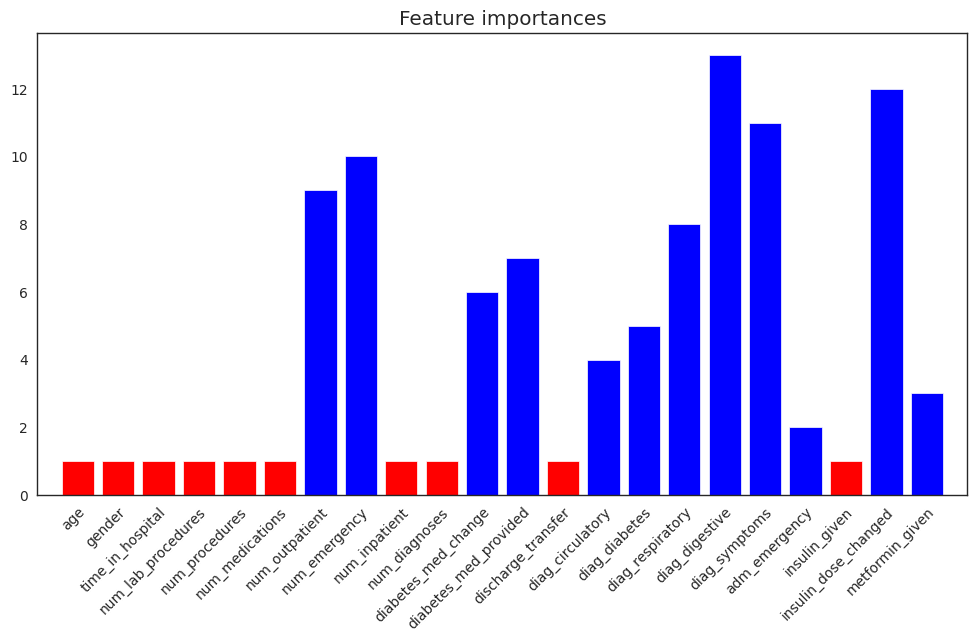

In [55]:
colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]

plt.figure(1, figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train_resampled.shape[1]), feature_rfe['ranking'],
       color=colors, align="center")
plt.xticks(range(X_train_resampled.shape[1]), X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train_resampled.shape[1]])
plt.show()

##### 4.4.1 Testing features

In [56]:
rf = RandomForestClassifier(
    n_estimators=100,
    # min_samples_leaf=20,
    max_depth=12,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
rf.fit(X_train_resampled[features], y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=38)

In [57]:
y_train_pred = rf.predict(X_train_resampled[features])
y_test_pred = rf.predict(X_test[features])

In [58]:
ac_train = accuracy_score(y_train_resampled, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.8324786324786325
Test accuracy:  0.6797352104796979


In [59]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     19513
           1       0.14      0.47      0.21      1938

    accuracy                           0.68     21451
   macro avg       0.53      0.59      0.50     21451
weighted avg       0.86      0.68      0.75     21451



<Axes: >

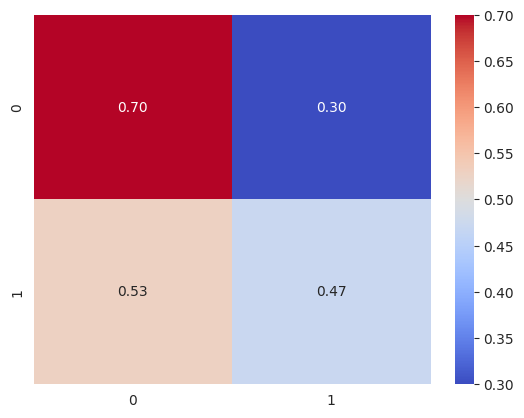

In [60]:
cm_rfe = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_rfe, annot=True, fmt=".2f", cmap='coolwarm')

### 4.5 Results Combined

#### 4.5.1 Confusion Matrices Combined

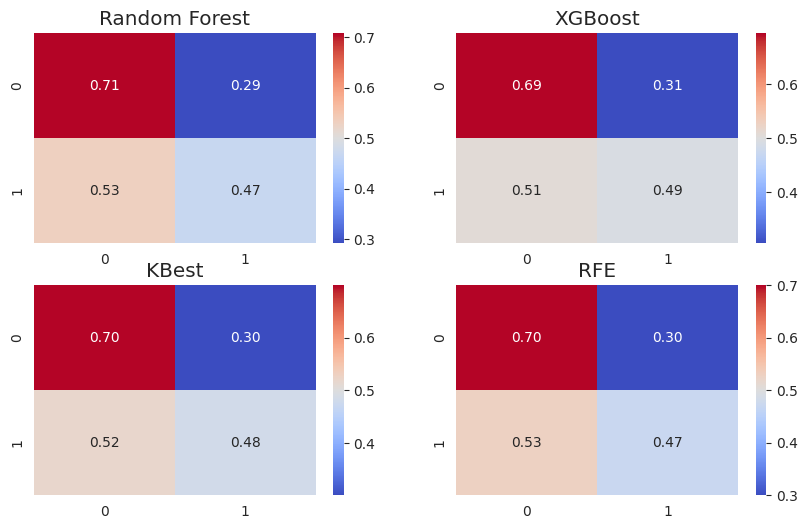

In [61]:
# Combine all confusion matrices into one single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
cm_list = [cm_rf, cm_xgb, cm_kbest, cm_rfe]
titles = ['Random Forest', 'XGBoost', 'KBest', 'RFE']

for i, cm in enumerate(cm_list):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(titles[i])
    
plt.show()

#### 4.5.2 Feature Importances Combined

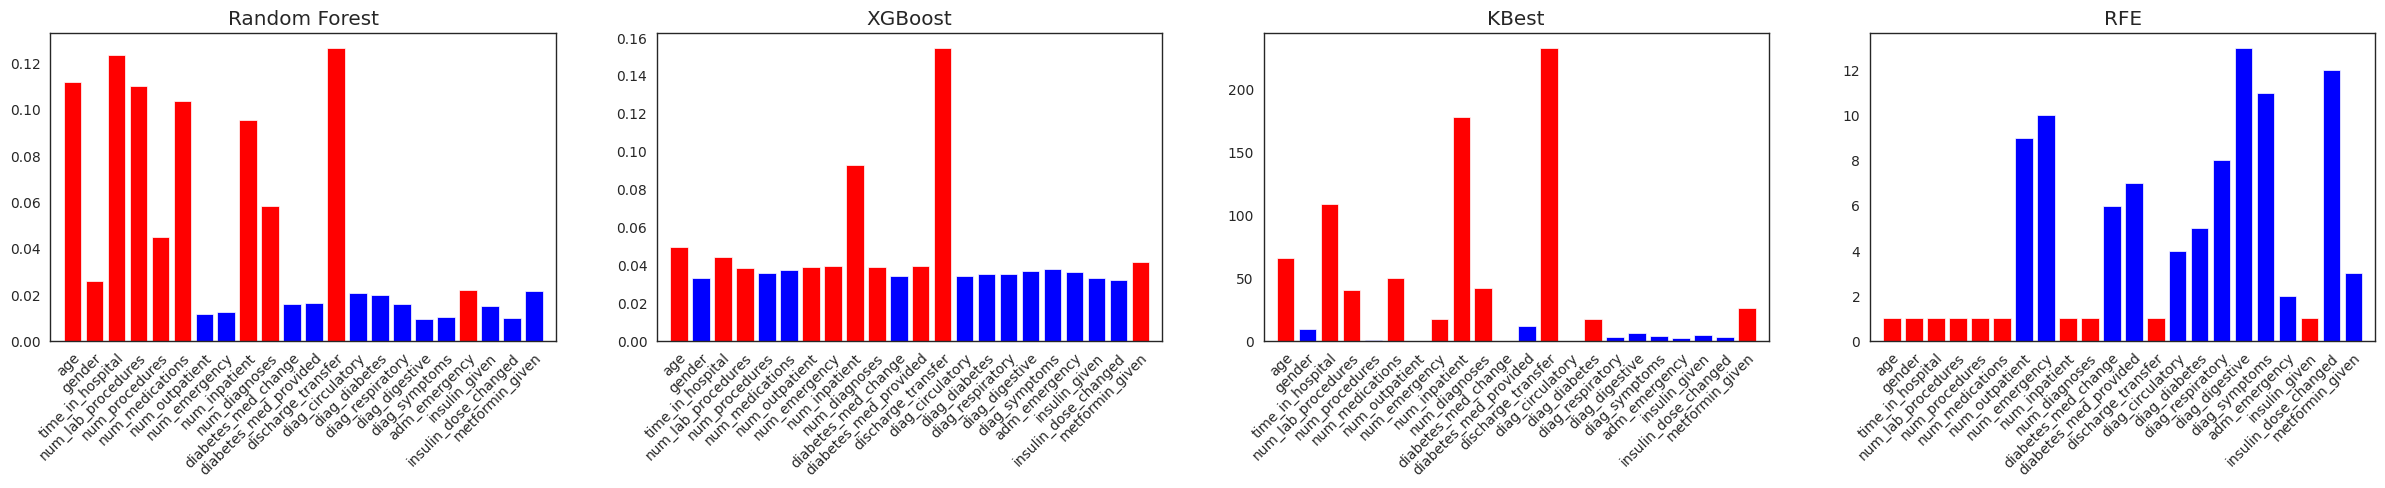

In [62]:
# Combine all feature importances plots into one single plot
fig, axs = plt.subplots(1, 4, figsize=(30, 4))
features_list = [features_rf, features_xgb, features_kbest, features_rfe]
importances_list = [importances_rf, importances_xgb, importances_kbest, importances_rfe]
titles = ['Random Forest', 'XGBoost', 'KBest', 'RFE']

# Plot without labels being covered by other plots
for i, (features, importances) in enumerate(zip(features_list, importances_list)):
    colors = ['r' if c in features else 'b' for c in X_train_resampled.columns]
    axs[i%4].bar(range(X_train_resampled.shape[1]), importances,
           color=colors, align="center")
    axs[i%4].set_title(titles[i])
    axs[i%4].set_xticks(range(X_train_resampled.shape[1]))
    axs[i%4].set_xticklabels(X_train_resampled.columns, rotation=45, ha='right', rotation_mode='anchor')
    axs[i%4].set_xlim([-1, X_train_resampled.shape[1]])
    
plt.show()

We select the $K$ features that appear most frequently across all selectors.

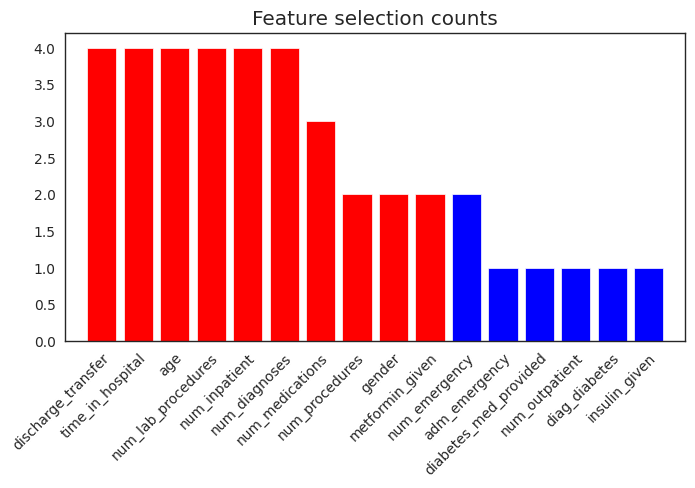

In [63]:
# Count the number of times each feature was selected
features = np.concatenate(features_list)
features = pd.Series(features)
features_counts = features.value_counts()

# Color the first K features selected by each method in red
colors = ['r' if c in features_counts.index[:K] else 'b' for c in features_counts.index]

# Plot the number of times each feature was selected
plt.figure(1, figsize=(8, 4))
plt.title("Feature selection counts")
plt.bar(range(len(features_counts)), features_counts,
       color=colors, align="center")
plt.xticks(range(len(features_counts)), features_counts.index, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, len(features_counts)])
plt.show()

## **5. Final Dataset**
Filtering the dataset with the selected features, generating training and test sets, and saving them.

### 5.1 Original dataset feature filtering

In [64]:
selected_features = features_counts.index[:K]
final_diabetic_data = diabetic_data[list(selected_features) + ['readmitted']]
final_diabetic_data.reset_index(drop=True, inplace=True)
final_diabetic_data

,discharge_transfer,time_in_hospital,age,num_lab_procedures,num_inpatient,num_diagnoses,num_medications,num_procedures,gender,metformin_given,readmitted
0,0,8.0,5.0,77,0,8,33,6,1,1,1
1,0,2.0,5.0,49,0,3,11,1,1,0,0
2,1,4.0,8.0,68,0,9,23,2,1,1,0
3,0,3.0,8.0,46,0,9,20,0,1,1,0
4,0,5.0,3.0,49,0,3,5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
71498,0,1.0,8.0,73,0,9,11,1,1,0,0
71499,0,3.0,6.0,56,0,7,8,1,0,0,0
71500,0,3.0,8.0,39,0,9,18,0,1,1,0
71501,1,13.0,4.0,69,0,5,16,0,1,1,0


### 5.2 Duplicates check

In [65]:
duplicated = final_diabetic_data[diabetic_data.duplicated()]
duplicated

,discharge_transfer,time_in_hospital,age,num_lab_procedures,num_inpatient,num_diagnoses,num_medications,num_procedures,gender,metformin_given,readmitted
7649,0,5.0,7.0,59,0,8,15,0,1,0,0
37869,0,2.0,6.0,43,0,9,11,0,0,0,0
46005,0,2.0,7.0,57,0,6,12,0,0,0,0
46942,0,5.0,7.0,64,0,9,14,0,0,1,0
66065,0,4.0,7.0,1,0,9,8,0,1,0,0


In [66]:
if not duplicated.empty:
    final_diabetic_data.drop_duplicates(inplace=True)
    final_diabetic_data.reset_index(drop=True, inplace=True)

/tmp/ipykernel_8300/1804674577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_diabetic_data.drop_duplicates(inplace=True)


### 5.3 Training & test split

In [67]:
# Split in training and test sets
X = final_diabetic_data.drop(columns='readmitted')
y = final_diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    final_diabetic_data.drop(columns='readmitted'),
    y,
    test_size=0.3, # 0.3 is good
    stratify=y,
    random_state=RANDOM_STATE
)

In [68]:
# Add the 'readmitted' column back to the training and test sets
train_data = X_train.copy()
train_data['readmitted'] = y_train

test_data = X_test.copy()
test_data['readmitted'] = y_test

In [69]:
final_diabetic_data['readmitted'].value_counts()

readmitted
0    64373
1     6460
Name: count, dtype: int64

In [70]:
train_data['readmitted'].value_counts()

readmitted
0    45061
1     4522
Name: count, dtype: int64

In [71]:
test_data['readmitted'].value_counts()

readmitted
0    19312
1     1938
Name: count, dtype: int64

### 5.4 Saving to CSV

In [72]:
train_set = pd.concat([X_train, y_train], axis=1)
train_set.to_csv(DATA_PATH_PROCESSED + 'train.csv', index=False)

In [73]:
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv(DATA_PATH_PROCESSED + 'test.csv', index=False)